In a real game of geoguessr, you are able to move the camera around and look at multiple images of the same location, so this allows the AI to make predictions on multiple images from the same location, in order to increase model accuracy and reliability.

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import os
from skimage.io import imread
import warnings

In [2]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
#from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow
import keras

In [3]:
model = keras.models.load_model('Backups/V3_MODEL (Good)/Backup_5')
#model = keras.models.load_model('Backups/V5_MODEL/Backup_12')

In [4]:
min_lat = 25.84
max_lat = 49.38
min_lon = -124.67
max_lon = -66.95

n_lats = len(np.unique(np.round(np.arange(min_lat, max_lat, 0.01))))
n_lons = len(np.unique(np.round(np.arange(min_lon, max_lon, 0.01))))

def center_crop(img, new_width=None, new_height=None):        

    width = img.shape[1]
    height = img.shape[0]

    if new_width is None:
        new_width = min(width, height)

    if new_height is None:
        new_height = min(width, height)

    left = int(np.ceil((width - new_width) / 2))
    right = width - int(np.floor((width - new_width) / 2))

    top = int(np.ceil((height - new_height) / 2))
    bottom = height - int(np.floor((height - new_height) / 2))

    if len(img.shape) == 2:
        center_cropped_img = img[top:bottom, left:right]
    else:
        center_cropped_img = img[top:bottom, left:right, ...]

    return center_cropped_img

def coord_to_onehot(coord):
    #Coordinate should be in [lat, lon] format
    lat = round(coord[0]) - round(min_lat)
    lon = abs(round(coord[1]) - round(min_lon))
    return (lat * n_lons) + lon

def onehot_to_coord(value):
    lon = value % n_lons
    lat = round((value - lon)/n_lons)
    return [round(lat) + round(min_lat), round(lon) + round(min_lon)]

def denormalize(coords):
    coordCopy = np.copy(coords)
    coordCopy[:,0] = (coordCopy[:,0] * n_lats) + min_lat
    coordCopy[:,1] = (coordCopy[:,1] * n_lons) + min_lon
    return coordCopy

def map_pred_categorical(pred, real=None):
    print(f'Prediction: {onehot_to_coord(np.argmax(pred))}')
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_axes([0.1,0.1,0.8,0.8])

    m = Basemap(llcrnrlon=-120.211606,llcrnrlat=20.837377,urcrnrlon=-60.158958,urcrnrlat=50.384359,
                rsphere=(6378137.00,6356752.3142),\
                resolution='l',area_thresh=1000.,projection='lcc',\
                lat_1=50,lon_0=-100.,ax=ax)

    
    m.drawmapboundary(fill_color='#0d0887')
    m.fillcontinents(color = '#0d0887',lake_color='#0d0887')

    lat, lon = np.meshgrid(np.linspace(round(min_lat), round(max_lat), n_lats), np.linspace(round(min_lon), round(max_lon), n_lons))
    lonm, latm = m(lon.reshape(-1), lat.reshape(-1))
    
    m.pcolormesh(lon, lat, np.transpose(pred.reshape(n_lats, n_lons)), latlon=True, zorder=2, cmap='plasma', shading='nearest')
    
    
    lonm, latm = m(lonCenter, latCenter)
    m.scatter(lonm, latm, marker = 'P', c = '#00ff12', zorder=100, s=250, alpha=1)
    
    if real != None:
        lonm, latm = m(real[1], real[0])
        m.scatter(lonm, latm, marker = '*', c = '#00ff12', zorder=100, s=250, alpha=1)

    predictCoords = onehot_to_coord(np.argmax(pred))
    lonm, latm = m(predictCoords[1], predictCoords[0])
    m.scatter(lonm, latm, marker = '+', c = '#371784', zorder=100, s=250, alpha=1)
    
    m.drawcoastlines()
    m.drawcountries()
    m.drawstates()
    #return fig
    
def map_pred_continuous(pred):
    pred = denormalize(pred)
    print(f'Prediction: {pred[0]}')
    if pred[0][0] < min_lat or pred[0][0] > max_lat or pred[0][1] < min_lon or pred[0][1] > max_lon:
        print('Invalid Output!')
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_axes([0.1,0.1,0.8,0.8])

    m = Basemap(llcrnrlon=-120.211606,llcrnrlat=20.837377,urcrnrlon=-60.158958,urcrnrlat=50.384359,
                rsphere=(6378137.00,6356752.3142),\
                resolution='l',area_thresh=1000.,projection='lcc',\
                lat_1=50,lon_0=-100.,ax=ax)

    
    m.drawmapboundary(fill_color='#0d0887')
    m.fillcontinents(color = '#0d0887',lake_color='#0d0887')
    
    lonm, latm = m(pred[0][1], pred[0][0])
    m.scatter(lonm, latm, marker = '*', c = '#00ff12', zorder=100, s=100, alpha=1)
    
    m.drawcoastlines()
    m.drawcountries()
    m.drawstates()
    #return fig

In [5]:
def calculate_centroid(pred, centerPoint, outlierRadius):
    lat, lon = np.meshgrid(np.linspace(round(min_lat), round(max_lat), n_lats), np.linspace(round(min_lon), round(max_lon), n_lons))
    
    #centerPoint should be in lat, lon format
    latInd = round(centerPoint[0] - min_lat)
    lonInd = round(centerPoint[1] - min_lon)
    
    lonPred = np.sum((lon * np.transpose(pred.reshape(n_lats, n_lons)))[max(0, lonInd-outlierRadius):min(n_lons, lonInd+outlierRadius), max(0, latInd-outlierRadius):min(n_lats, latInd+outlierRadius)]) 
    latPred = np.sum((lat * np.transpose(pred.reshape(n_lats, n_lons)))[max(0, lonInd-outlierRadius):min(n_lons, lonInd+outlierRadius), max(0, latInd-outlierRadius):min(n_lats, latInd+outlierRadius)]) 
    
    magnitudeAdjustment = np.sum(np.transpose(pred.reshape(n_lats, n_lons))[max(0, lonInd-outlierRadius):min(n_lons, lonInd+outlierRadius), max(0, latInd-outlierRadius):min(n_lats, latInd+outlierRadius)])
    
    lonPred /= magnitudeAdjustment
    latPred /= magnitudeAdjustment
    
    print(f'Prediction: {latPred}, {lonPred}')
    
    return latPred, lonPred
    
    
def calculate_coords_from_prediction(pred):
    #Start of prediction calculation
    #print(f'Max confidence: {np.max(pred)}')
    outlierRadius = 5
    
    lat, lon = np.meshgrid(np.linspace(round(min_lat), round(max_lat), n_lats), np.linspace(round(min_lon), round(max_lon), n_lons))
    
    lonCenter = np.sum(lon * np.transpose(pred.reshape(n_lats, n_lons)))
    latCenter = np.sum(lat * np.transpose(pred.reshape(n_lats, n_lons)))
    
    lonInd = round(lonCenter - min_lon)
    latInd = round(latCenter - min_lat)
    
    #If very high confidence in first guess
    return calculate_centroid(pred, onehot_to_coord(np.argmax(pred)), 1)
    if (np.sort(pred)[-1] / np.sort(pred)[-2]) > 1:
        #print('Very confident guess!')
        1+1
    
    #If very low confidence in center of mass
    if np.sum(np.transpose(pred.reshape(n_lats, n_lons))[max(0, lonInd-outlierRadius):min(n_lons, lonInd+outlierRadius), max(0, latInd-outlierRadius):min(n_lats, latInd+outlierRadius)]) < 0.5:
        return calculate_centroid(pred, onehot_to_coord(np.argmax(pred)), 10)
    
    #For most predictions, calculate centroid of nearest 80% of weight
    for i in range(1, 30):
        if np.sum(np.transpose(pred.reshape(n_lats, n_lons))[max(0, lonInd-i):min(n_lons, lonInd+i), max(0, latInd-i):min(n_lats, latInd+i)]) > 0.5:
            #print(f'Prediction radius: {i}')
            return calculate_centroid(pred, [latCenter, lonCenter], i)

def map_pred_categorical(pred, real=None):
    print(f'Highest confidence: {onehot_to_coord(np.argmax(pred))}')
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_axes([0.1,0.1,0.8,0.8])

    m = Basemap(llcrnrlon=-120.211606,llcrnrlat=20.837377,urcrnrlon=-60.158958,urcrnrlat=50.384359,
                rsphere=(6378137.00,6356752.3142),\
                resolution='l',area_thresh=1000.,projection='lcc',\
                lat_1=50,lon_0=-100.,ax=ax)

    
    m.drawmapboundary(fill_color='#0d0887')
    m.fillcontinents(color = '#0d0887',lake_color='#0d0887')

    lat, lon = np.meshgrid(np.linspace(round(min_lat), round(max_lat), n_lats), np.linspace(round(min_lon), round(max_lon), n_lons))
    lonm, latm = m(lon.reshape(-1), lat.reshape(-1))
    
    m.pcolormesh(lon, lat, np.transpose(pred.reshape(n_lats, n_lons)), latlon=True, zorder=2, cmap='plasma', shading='nearest')
    
    latPred, lonPred = calculate_coords_from_prediction(pred)
    
    lonm, latm = m(lonPred, latPred)
    m.scatter(lonm, latm, marker = 'P', c = '#ff0000', zorder=101, s=250, alpha=1)
    
    #lonm, latm = m(lonCenter, latCenter)
    #m.scatter(lonm, latm, marker = 'P', c = '#00ff12', zorder=100, s=250, alpha=1)
    
    if real != None:
        lonm, latm = m(real[1], real[0])
        m.scatter(lonm, latm, marker = '*', c = '#00ff12', zorder=100, s=250, alpha=1)

    predictCoords = onehot_to_coord(np.argmax(pred))
    lonm, latm = m(predictCoords[1], predictCoords[0])
    m.scatter(lonm, latm, marker = '+', c = '#371784', zorder=100, s=250, alpha=1)
    
    m.drawcoastlines()
    m.drawcountries()
    m.drawstates()
    #return fig

In [6]:
#(Done) POTENTIAL IMPROVEMENT: Make a maximum radius around most confident guess (old prediction) or the mean location for points to influence the mean. This prevents outliers causing problems
#POTENTIAL IMPROVEMENT: Find a way to measure how spread out/inconsistent a given guess space is, then change search parameters based on that.
    #possible method: np.max(np.mean(predictions, axis=0)) low = not spread out, high = very confident in max point

In [7]:
inputDir = 'Games/loc/'

Loaded 36 images


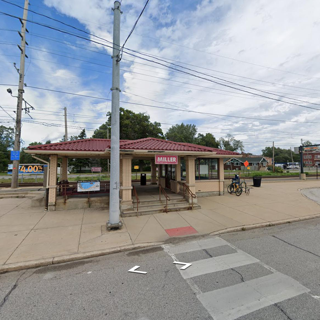

In [15]:
imageNames = os.listdir(inputDir)
images = []
for imageName in imageNames:
    img = imread(inputDir + imageName)
    img = Image.fromarray(center_crop(img))
    img = img.resize((320,320))
    images.append(np.array(img))
images = np.array(images)
print(f'Loaded {len(images)} images')
Image.fromarray(images[0])

Highest confidence: [28, -82]
Prediction: 27.721933763538576, -82.087106046706


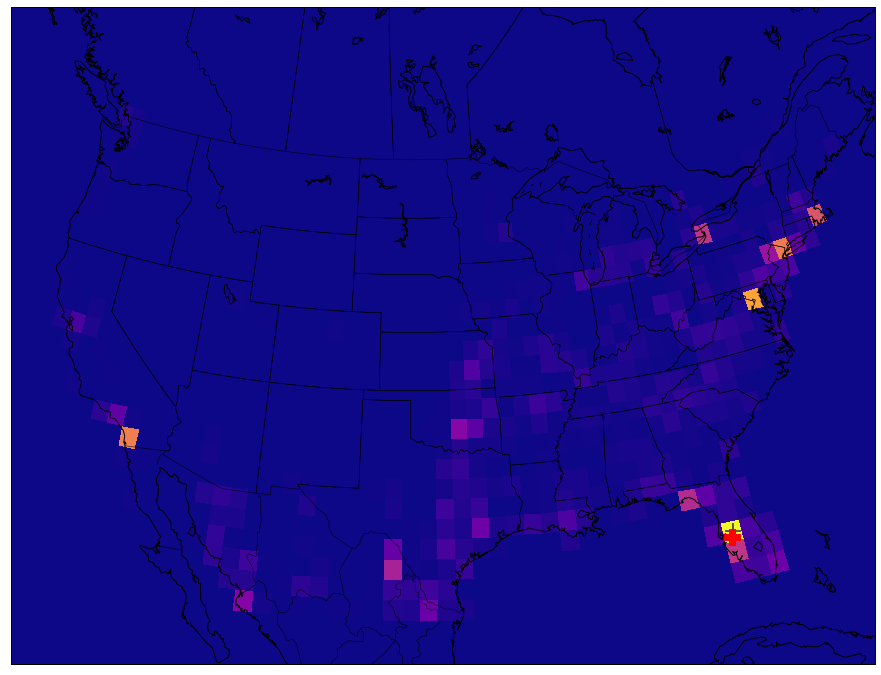

In [16]:
predictions = model.predict(np.array([preprocess_input(image) for image in images]))
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    map_pred_categorical(np.mean(predictions, axis=0))

In [ ]:
[preprocess_input(image) for image in images][0]

In [19]:
np.sum(np.mean(predictions, axis=0))

1.0000001

In [25]:
print(np.sort(np.mean(predictions, axis=0))[-10:])

[0.02295322 0.02333752 0.02347566 0.0270544  0.02964215 0.02986548
 0.03016738 0.03618096 0.11395541 0.1166396 ]


In [ ]:
np.sort(pred)[-1] / np.sort(pred)[-2]